# Численные методы. Проектная работа. 
# Определение стоимости автомобилей

## Описание проекта.

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

* качество предсказания
* скорость предсказания
* время обучения

## Подготовка данных

Импротируем необходимые библиотети и загрузим данные

In [3]:
import pandas as pd
import numpy as np
import re
import datetime



import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from catboost import Pool, CatBoostClassifier, CatBoostRegressor


import lightgbm as lgb

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

import warnings
warnings.filterwarnings('ignore')

In [4]:
random_magic = 1024

In [5]:
try:
    data = pd.read_csv('autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [6]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Набор данных предстален 16 столбцами и 354369 строками.

Признаки:

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак:

* Price — цена (евро)

В таблице 9 строковых и 7 целочисленных атрибутов, нужно преобразовать столбцы с датами в тип данных даты.

Имеются пропуски в столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired.

Необходимо приведение названий признаков к "змеиному регистру".

Кроме того, в отдельных атрибутах явно имеются аномальные значения:

* '9999' - год регистрации
* 0 - месяц регистрации
* 0 - цена автомобиля
* 20000 - мощность (л. с.)

Решение о способе вставки пропусков и замены указанных аномальных значений целесообразно принять на этапе последующего изучения и предобработки данных.

Данные объявлений также содержат персональную информацию пользователей - почтовый код и время последней активности (видимо, на ресурсе, где представлены объявления), которые целесообразно сразу исключить из рассмотрения.

Помимо прочего в данных содержатся признаки, описывающие само объявление, а не продаваемый автомобиль - количество фотографий, дата создания и выгрузки объявления. При этом признак количества фотографий содержит только одно значение - 0. Этот признак также целесообразно сразу исключить из рассмотрения.

## Подготовка данных

Приведем названия признаков к " змеиному регистру"

In [9]:
data.rename(columns=lambda x: re.sub('(?!^)([A-Z]+)', r'_\1',x).lower(), inplace=True)
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Выполним преобразование типа данных для дат.

In [10]:
data['date_crawled'] = pd.to_datetime(data['date_crawled'])
data['date_created'] = pd.to_datetime(data['date_created'])

Проверим данные на дубликаты

In [11]:
duplicates = data[data.duplicated()] 
duplicates

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


Удалим их.

In [12]:
data = data.drop_duplicates().reset_index(drop=True)

Рассморим один интересный момент. Признак "была машина в ремонте или нет" допускает разное толкование. Если мы будем опираться на английское название столбца 'not repaired', то оно будет скорее трактоваться как "не отремотирована" - то есть ответ 'yes' говорит, что она находится в битом состоянии, а ответ 'no' - отремонтирована, то есть на ходу.

Если же мы обратимся к русской трактовке признака, которая дана в описании данных, то на вопрос "была машина в ремонте или нет" положительный ответ "да" будет означать, что она отремонтирована. Для прояснения ситуации отдельно исследуем этот признак.

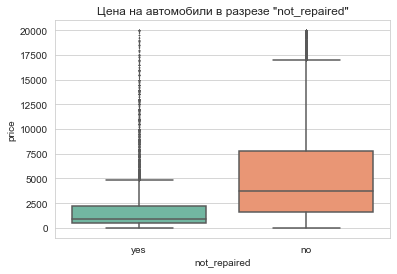

In [13]:
sns.set_style('whitegrid')
sns.boxplot(data = data, x='not_repaired', y='price', palette='Set2', fliersize=0.5)
plt.title('Цена на автомобили в разрезе "not_repaired"');

In [14]:
data['not_repaired'].value_counts()

no     247158
yes     36053
Name: not_repaired, dtype: int64

В объявлениях, где в 'not_repaired' указан ответ 'no' - медианная цена гораздо выше, чем там, где 'yes'. Значит, мы для себя можем определить, что этот признак выражает на ходу машина или нет.

'not_repaired' - 'не отремонтирована': 'no' - нет, не "не отремонтирована" - значит, на ходу; 'yes' - да, "не отремонтирована", значит, не на ходу.

Также анализ объявления реальных площадок показал, что есть такой параметр как "битая" - и там объявления машин после аварий. Значит, признак 'not_repaired' для нас выступает в роли такого флажка - 'no' - все в порядке, можно ездить, 'yes' - битая, ездить вряд ли получится.

Если бы это был реальная задача, ты мы бы сделали запрос в источнику выгрузки базы данных.

Рассмотрим остальные признаки поподробнее

In [15]:
data.sort_values(by='date_crawled', ascending=True)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
329493,2016-03-05 14:06:22,150,small,1997,manual,75,polo,150000,4,petrol,volkswagen,no,2016-03-05,0,35789,2016-03-27 17:16:15
220582,2016-03-05 14:06:23,3999,wagon,2003,manual,220,a6,150000,7,petrol,audi,no,2016-03-05,0,57080,2016-03-06 18:29:35
176822,2016-03-05 14:06:24,6200,convertible,2006,manual,135,megane,90000,9,petrol,renault,no,2016-03-05,0,35764,2016-03-24 09:16:44
324760,2016-03-05 14:06:24,799,small,1997,manual,60,polo,150000,11,petrol,volkswagen,no,2016-03-05,0,35708,2016-03-09 15:19:01
99885,2016-03-05 14:06:24,10900,suv,2003,auto,245,NaN,150000,11,petrol,sonstige_autos,no,2016-03-05,0,56072,2016-04-06 22:15:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204217,2016-04-07 14:36:53,6990,coupe,1979,auto,143,3er,150000,6,petrol,bmw,no,2016-04-07,0,71336,2016-04-07 14:36:53
53739,2016-04-07 14:36:54,400,small,1996,manual,60,ibiza,150000,0,NaN,seat,NaN,2016-04-07,0,66299,2016-04-07 14:36:54
301027,2016-04-07 14:36:55,15200,wagon,2008,manual,190,a6,150000,9,gasoline,audi,no,2016-04-07,0,81476,2016-04-07 14:36:55
339645,2016-04-07 14:36:56,8650,suv,1992,manual,121,wrangler,125000,5,petrol,jeep,no,2016-04-07,0,20357,2016-04-07 14:36:56


Скачанные из базы анкеты охватывают временной промежуток около месяца - примерно март 2016 года.

In [16]:
data.sort_values(by='date_created', ascending=True)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
61207,2016-03-16 11:48:06,8999,NaN,2005,NaN,0,147,125000,0,petrol,alfa_romeo,NaN,2014-03-10,0,79669,2016-04-07 04:46:24
4001,2016-03-23 14:42:46,6000,bus,1995,auto,200,other,150000,0,petrol,chevrolet,no,2015-03-20,0,24558,2016-04-07 03:45:01
342271,2016-03-05 21:44:26,10400,bus,1993,NaN,0,ducato,30000,1,gasoline,fiat,NaN,2015-06-18,0,76275,2016-04-05 17:46:09
86601,2016-04-02 19:47:40,14250,convertible,2005,manual,163,slk,150000,6,petrol,mercedes_benz,no,2015-08-07,0,76228,2016-04-07 09:15:23
175102,2016-03-08 17:57:45,5200,convertible,2006,manual,109,2_reihe,80000,11,petrol,peugeot,no,2015-08-10,0,26382,2016-04-05 20:46:54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184410,2016-04-07 00:36:23,550,small,1997,manual,60,ka,150000,0,petrol,ford,no,2016-04-07,0,59077,2016-04-07 00:36:23
262337,2016-04-07 03:36:20,2190,wagon,1998,manual,110,a4,150000,6,gasoline,audi,no,2016-04-07,0,66606,2016-04-07 03:36:20
214461,2016-04-07 03:25:37,1890,wagon,2000,manual,150,a4,5000,8,gasoline,audi,no,2016-04-07,0,63065,2016-04-07 08:06:18
241967,2016-04-07 13:36:25,15490,convertible,2010,manual,150,c_reihe,125000,6,gasoline,volvo,no,2016-04-07,0,52076,2016-04-07 13:36:25


При этом анкеты создавались в течение двух лет - с марта 2014 года.

In [17]:
data.sort_values(by='last_seen', ascending=True)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
296782,2016-03-05 14:07:08,550,small,2001,manual,75,corsa,150000,5,NaN,opel,yes,2016-03-05,0,65232,2016-03-05 14:15:08
262338,2016-03-05 14:08:46,9000,sedan,2011,manual,109,c_reihe,90000,3,gasoline,volvo,no,2016-03-04,0,61348,2016-03-05 14:15:16
130462,2016-03-05 14:13:50,1200,wagon,2000,manual,115,passat,150000,5,NaN,volkswagen,no,2016-03-03,0,35606,2016-03-05 14:15:39
285692,2016-03-05 14:18:30,2850,sedan,1990,NaN,0,other,150000,2,petrol,mercedes_benz,no,2016-03-03,0,35781,2016-03-05 14:18:30
169065,2016-03-05 14:06:47,599,small,1997,manual,50,polo,100000,4,petrol,volkswagen,no,2016-03-05,0,60489,2016-03-05 14:25:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59506,2016-03-21 16:29:26,6250,wagon,2005,auto,204,a4,150000,9,gasoline,audi,no,2016-03-21,0,65620,2016-04-07 14:58:50
290309,2016-03-19 23:42:29,1459,wagon,1998,manual,90,golf,150000,8,gasoline,volkswagen,no,2016-03-19,0,74078,2016-04-07 14:58:50
245596,2016-03-19 21:53:27,9000,suv,2007,auto,218,other,150000,2,gasoline,jeep,no,2016-03-19,0,22391,2016-04-07 14:58:50
68870,2016-03-21 16:06:19,11200,convertible,2002,auto,231,3er,125000,1,petrol,bmw,no,2016-03-21,0,55425,2016-04-07 14:58:50


Пользователи также появлялись на сайте в течение последнего месяца, значит, можно говорить о том, что ценовые данные даже для старых объявлений - актуальны.

Удалим признаки "количество фотографий автомобиля", "почтовый код" и "время последней активности".

In [18]:
data.drop(columns=['number_of_pictures', 'postal_code', 'last_seen'], inplace=True)

Чтобы оценить, адекватные ли в нашей базе данные, построим ящики с усами

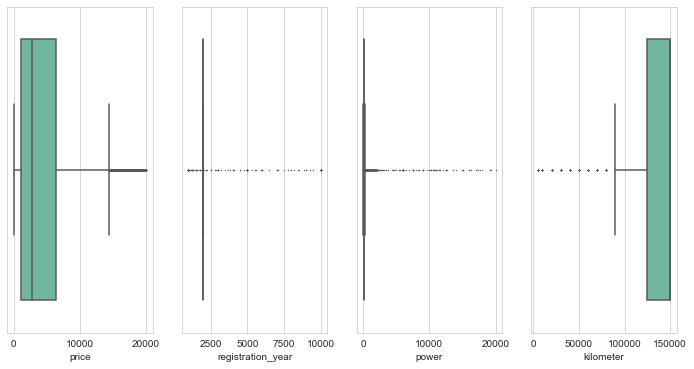

In [19]:
features_to_plot = {'price':0, 'registration_year':1, 'power':2,'kilometer':3}
fig, axes = plt.subplots(1,4, figsize = (12,6))
for feature, pos in features_to_plot.items():
    sns.boxplot(x=data[feature], orient='h', palette='Set2', fliersize=0.5, ax=axes[pos]);

'price' - медиана по цене составляет около 2700 тыс. евро, видимо, в основном представлены бюджетные автомобили.
Есть автомобили с ценой 0 - нам предстоит понять, что это - неявные пропуски или продавцы отдают в дар.

'regisrtation_year' - много значений выше 2500, похоже, на ошибки, нужно будет посмотреть на них и, скорее всего, избавиться.

'power' - также неадекватно высокая мощность, возможно, предстоит избавиться.

'kilometer' - столбец с пробегом не вызывает подозрений, кроме того, что медиана - 150 тыс. км и максимальное значение такое же. Возможно, при выгрузке данных стоял какой-то фильтр, например, пробег не более 150 000 км, поэтому будем работать с тем, что есть.

Посмотрим на обьявления с неадекватно низкой ценой, менее 100 евро

In [20]:
df = data.query('price < 100')
df['price'].value_counts()

0     10772
1      1189
50      327
80      146
99      109
10       84
70       69
60       58
30       55
75       54
20       51
40       45
90       41
25       33
15       27
5        26
55       20
65       19
35       18
45       16
95       13
2        12
49       12
85       11
8         9
3         8
9         8
12        8
13        7
39        6
59        6
11        5
17        5
14        5
79        4
18        3
7         3
89        3
69        3
19        3
66        2
16        2
98        2
29        2
33        1
24        1
4         1
88        1
47        1
38        1
21        1
32        1
58        1
27        1
26        1
74        1
77        1
Name: price, dtype: int64

10772 обьявления, возможно, это автомобили не на ходу, посмотрим имел ли место ремонт.

In [21]:
low_price = data.query('price < 100')
low_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13314 entries, 7 to 354360
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date_crawled        13314 non-null  datetime64[ns]
 1   price               13314 non-null  int64         
 2   vehicle_type        8436 non-null   object        
 3   registration_year   13314 non-null  int64         
 4   gearbox             9795 non-null   object        
 5   power               13314 non-null  int64         
 6   model               10642 non-null  object        
 7   kilometer           13314 non-null  int64         
 8   registration_month  13314 non-null  int64         
 9   fuel_type           8768 non-null   object        
 10  brand               13314 non-null  object        
 11  not_repaired        6517 non-null   object        
 12  date_created        13314 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(5), object(6)
mem

In [22]:
low_price['not_repaired'].value_counts()

no     3955
yes    2562
Name: not_repaired, dtype: int64

Исследования показывают, что 3955 автомобилей с очень низкой ценой были отремонтированы, 2005 - нет и остальная часть объявлений с низкой ценой без данных о ремонте. То есть, если бы мы однозначно увидели, что все автомобили с низкой ценой в столбце 'not_repaired' имеют 'yes' - то есть они были бы не находу - тогда мы теоретически могли бы сказать, что в этом срезе у нас автохлам. С учетом того, что это целевой признак, проявлять фантазию и пытаться заполнить модами или медианами выглядит опасным, поэтому придется избавиться от этих данных.

In [23]:
data = data.query('price >= 100')

Разберем подробно столбец с пропусками о ремонте, попробуем воссстановить данные.
Отберем объявления, где указано, что машина в ремонте не была.

In [24]:
data[data['not_repaired'] == 'no'].describe(include='all')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created
count,243203,243203.000000,230960,243203.000000,237887,243203.000000,235393,243203.000000,243203.000000,231567,243203,243203,243203
unique,202218,NaN,8,NaN,2,NaN,249,NaN,NaN,7,40,1,106
top,2016-04-01 19:25:23,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00
freq,5,NaN,67913,NaN,188287,NaN,20021,NaN,NaN,152129,52076,243203,9592
first,2016-03-05 14:06:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-03-20 00:00:00
last,2016-04-07 14:36:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-07 00:00:00
mean,NaN,5382.956275,NaN,2003.728252,NaN,118.680156,NaN,126347.783539,6.156947,NaN,NaN,NaN,NaN
std,NaN,4713.314469,NaN,23.351333,NaN,162.198871,NaN,37725.380574,3.503280,NaN,NaN,NaN,NaN
min,NaN,100.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN
25%,NaN,1699.000000,NaN,2000.000000,NaN,75.000000,NaN,100000.000000,3.000000,NaN,NaN,NaN,NaN


Средняя стоимость этих авто 4382 евро, медианная - 3799. 

Посмотрим на те же метрики у объявлений, где указано, что авто было в ремонте.

In [25]:
data[data['not_repaired'] == 'yes'].describe(include='all')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created
count,33491,33491.000000,30176,33491.000000,32211,33491.000000,31455,33491.000000,33491.000000,30089,33491,33491,33491
unique,32696,NaN,8,NaN,2,NaN,241,NaN,NaN,7,40,1,53
top,2016-03-23 17:52:48,NaN,small,NaN,manual,NaN,other,NaN,NaN,petrol,volkswagen,yes,2016-03-21 00:00:00
freq,3,NaN,8274,NaN,26489,NaN,2833,NaN,NaN,21423,6464,33491,1292
first,2016-03-05 14:06:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-04 00:00:00
last,2016-04-07 14:36:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-07 00:00:00
mean,NaN,2061.949539,NaN,2001.748619,NaN,104.216177,NaN,136339.464334,5.410468,NaN,NaN,NaN,NaN
std,NaN,2716.066155,NaN,45.927596,NaN,217.489307,NaN,31627.337747,3.775984,NaN,NaN,NaN,NaN
min,NaN,100.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN
25%,NaN,500.000000,NaN,1998.000000,NaN,60.000000,NaN,150000.000000,2.000000,NaN,NaN,NaN,NaN


Средняя стимость этих автомобилей 2061 евро, медиана - 1000.

Теперь посмотрим на объявления, где наличие или отсутствие ремонта не указано.

In [26]:
data[data['not_repaired'].isna()].describe(include='all')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created
count,64357,64357.000000,47303,64357.000000,54639,64357.000000,57170,64357.000000,64357.000000,51046,64357,0,64357
unique,60954,NaN,8,NaN,2,NaN,244,NaN,NaN,7,40,0,71
top,2016-04-05 16:06:36,NaN,small,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,NaN,2016-04-03 00:00:00
freq,3,NaN,14033,NaN,45296,NaN,5705,NaN,NaN,36043,15392,NaN,2474
first,2016-03-05 14:06:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-10 00:00:00
last,2016-04-07 14:36:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-07 00:00:00
mean,NaN,2903.128517,NaN,2005.961838,NaN,87.604006,NaN,132542.769240,4.647902,NaN,NaN,NaN,NaN
std,NaN,3418.319729,NaN,150.542185,NaN,251.438069,NaN,37229.792563,4.055533,NaN,NaN,NaN,NaN
min,NaN,100.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN
25%,NaN,700.000000,NaN,1998.000000,NaN,0.000000,NaN,150000.000000,0.000000,NaN,NaN,NaN,NaN


Здесь средняя стоимость 2903 евро и медиана 1600. Можно было бы сделать выбор в пользу заполнения параметром "yes", так как цены больше тяготеют к выборке автомобилей, бывших в ремонте, но всё же не будем рисковать,ситуация, когда факт проведения ремонта не указан, все-таки отличается от ситуации, когда указано, что автомобиль не ремонтировался. Но и удалять такой массив данных не хотелось бы, поэтому принято решение вместо пропусков создать отдельную категорию - unknown.

In [27]:
data['not_repaired'] = data['not_repaired'].fillna('unknown')

Далее проанализируем признак 'год регистрации'. В наших данных не может быть автомобилей с годом регистрации больше 2016, была версия, что данные пополнялись но она разбилась о дату регистрации анкеты, объявление не могло быть опубликовано ранее, чем автомобиль был зарегистрирован.

In [28]:
data[data['registration_year'] >= 2017].describe(include='all')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created
count,13687,13687.000000,19,13687.000000,12009,13687.000000,11844,13687.000000,13687.000000,8484,13687,13687,13687
unique,13538,NaN,8,NaN,2,NaN,227,NaN,NaN,7,40,3,43
top,2016-03-23 11:56:04,NaN,wagon,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-03-14 00:00:00
freq,3,NaN,4,NaN,10154,NaN,1498,NaN,NaN,5996,3566,6731,527
first,2016-03-05 14:07:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-22 00:00:00
last,2016-04-07 13:36:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-07 00:00:00
mean,NaN,3346.247315,NaN,2038.283481,NaN,88.595675,NaN,132181.997516,4.822094,NaN,NaN,NaN,NaN
std,NaN,3471.899965,NaN,341.860353,NaN,248.733286,NaN,36193.164734,3.994002,NaN,NaN,NaN,NaN
min,NaN,100.000000,NaN,2017.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN
25%,NaN,1099.000000,NaN,2017.000000,NaN,11.000000,NaN,125000.000000,1.000000,NaN,NaN,NaN,NaN


In [29]:
display(data[data['registration_year']  >= 2017])

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,unknown,2016-03-25
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354108,2016-03-11 15:49:51,3600,NaN,2017,manual,86,transit,150000,5,gasoline,ford,unknown,2016-03-11
354136,2016-03-29 16:47:29,1000,NaN,2017,manual,101,a4,150000,9,NaN,audi,unknown,2016-03-29
354199,2016-03-17 00:56:26,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no,2016-03-17
354249,2016-03-25 09:37:59,1250,NaN,2018,NaN,0,corsa,150000,0,petrol,opel,unknown,2016-03-25


Информация о данных этого среза и визуальный осмотр объявлений говорит нам о том, что здесь не наблюдается определенной системы в пропусках - представлены машины различных брендов и моделей, типов топлива. При этом почти у всех у них есть пропуски в типе кузова. Почему эти машины попали в нашу выборку из будущего выяснить не представляется возможным, удалим эти данные.

In [30]:
data = data.query('registration_year <= 2017')

Посчитаем долю объявлений по очень старым автомобилям.

In [31]:
display('Доля объявлений с указанием года регистрации до 1980: {0:.2%}'
      .format(data.query('registration_year < 1980')['registration_year'].count() / data.shape[0]))

'Доля объявлений с указанием года регистрации до 1980: 0.91%'

Без сожалений избавляемся и от них.

Кроме того, удалим данные имеющие большое количество пропусков/аномалий. Значение марки автомобиля sonstige_autos с немецкого - прочие автомобили, что никак не добавляет ясности в наши данные.

In [32]:
data.drop(
    data.query('vehicle_type.isnull() and gearbox.isnull() and power == 0 \
              and fuel_type.isnull() and brand==\'sonstige_autos\' and not_repaired.isnull()', engine='python').index,
    inplace=True
)

In [33]:
data = data.query('registration_year >= 1980')

In [34]:
data['registration_month'].value_counts()

3     33015
0     30262
6     30146
4     28029
5     27913
7     25924
10    25202
11    23359
12    23343
9     22949
1     21954
8     21711
2     20326
Name: registration_month, dtype: int64

Объявлений с 0 в качестве месяца регистрации порядка 10% от общего числа объявлений. С учетом того, что данные по месяцу регистрации распределены достаточно равномерно, то и замену значения 0 целесообразно сделать таким образом, чтобы не изменить исходное распределение.

Сделаем замену случайным образом на число из диапазона (1, 12) - для этого индекс записи приведем к модулю 12 и добавим 1.

In [35]:
data.loc[data['registration_month'] == 0, 'registration_month'] = (
    data.query('registration_month == 0').index % 12 + 1
)

In [36]:
data['registration_month'].value_counts()

3     35547
6     32629
5     30514
4     30490
7     28409
10    27788
11    25854
12    25819
9     25442
1     24483
8     24253
2     22905
Name: registration_month, dtype: int64

Выше было отмечено, что значение sonstige_autos является аномальным (соответствует категории прочие марки автомобилей). Очевидно, что марка автомобиля является одним из ключевых признаков - определяет модель, а также неявно определяет многие прочие характеристики (например, в заданный период производитель может выпускать только автомобили определенного типа кузова или определенной мощности). Необходимо оценить долю автомобилей без указания марки в общем объеме объявлений.

In [37]:
data.query('brand == \'sonstige_autos\'')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created
306,2016-03-21 14:38:37,200,NaN,2009,NaN,0,NaN,10000,7,NaN,sonstige_autos,unknown,2016-03-21
431,2016-03-20 20:45:27,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,no,2016-03-20
661,2016-04-01 15:56:27,9900,suv,2000,auto,250,NaN,150000,4,lpg,sonstige_autos,no,2016-04-01
700,2016-03-30 21:37:21,6999,sedan,2010,auto,186,NaN,125000,4,petrol,sonstige_autos,no,2016-03-30
985,2016-03-15 16:37:22,500,sedan,2010,manual,101,NaN,70000,1,petrol,sonstige_autos,yes,2016-03-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
353888,2016-03-06 11:42:12,7900,bus,2009,NaN,140,NaN,125000,7,gasoline,sonstige_autos,no,2016-03-06
354058,2016-03-19 11:25:16,6000,small,2008,manual,155,NaN,150000,5,petrol,sonstige_autos,no,2016-03-19
354069,2016-03-19 14:53:26,1750,NaN,1995,NaN,0,NaN,100000,12,NaN,sonstige_autos,unknown,2016-03-19
354317,2016-03-15 13:52:34,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,2016-03-15


In [38]:
data.query('brand==\'sonstige_autos\' and (vehicle_type.isnull() or gearbox.isnull() or power == 0 \
              or fuel_type.isnull() or not_repaired.isnull() or price in (0, 1))', engine='python')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created
306,2016-03-21 14:38:37,200,NaN,2009,NaN,0,NaN,10000,7,NaN,sonstige_autos,unknown,2016-03-21
999,2016-04-02 23:39:49,3900,wagon,1990,manual,0,NaN,30000,5,petrol,sonstige_autos,unknown,2016-04-02
1345,2016-03-21 01:57:37,899,NaN,1990,NaN,37,NaN,60000,2,NaN,sonstige_autos,unknown,2016-03-21
1537,2016-03-18 00:55:38,300,NaN,2010,NaN,0,NaN,150000,12,NaN,sonstige_autos,unknown,2016-03-18
1744,2016-03-31 17:52:56,4600,other,2008,manual,0,NaN,150000,5,gasoline,sonstige_autos,unknown,2016-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
353329,2016-03-12 15:45:52,199,NaN,2016,manual,0,NaN,150000,3,petrol,sonstige_autos,no,2016-03-12
353547,2016-03-17 20:44:46,900,other,1988,NaN,0,NaN,5000,11,NaN,sonstige_autos,no,2016-03-17
353888,2016-03-06 11:42:12,7900,bus,2009,NaN,140,NaN,125000,7,gasoline,sonstige_autos,no,2016-03-06
354069,2016-03-19 14:53:26,1750,NaN,1995,NaN,0,NaN,100000,12,NaN,sonstige_autos,unknown,2016-03-19


Доля автомобилей без указания марки составляет всего 0.6% (ближе к нижней части списка частот встречаемости). Кроме того, среди указанных автомобилей есть те, для которых не указаны и прочие параметры - мощность, тип кузова, тип коробки передач. 

Целесообразно удалить все данные об автомобилях без указания марки, поскольку их доля в общем объеме мала и кроме того среди этих данных много пропусков/аномалий в прочих атрибутах.

In [39]:
data = data.query('brand != \'sonstige_autos\'')

Для последующего стратифицированного разделения данных, целесообразно добавить дополнительный атрибут, позволяющий отделить модели, занимающие менее 1% рынка от других.

In [40]:
top_models = [
    'volkswagen',        
    'opel',
    'bmw',
    'mercedes_benz', 
    'audi',
    'ford',
    'renault',
    'peugeot',
    'fiat',
    'seat',
    'mazda',
    'skoda',
    'smart',
    'citroen',
    'nissan',
    'toyota',
    'hyundai',
]

In [41]:
data['brand_type'] = data.apply(
    lambda row: row['brand'] if row['brand'] in top_models else 'other',    
    axis=1
)

Оценим значения мощностей двигателей в представленном наборе данных.
Сразу отбросим объявление с указанной мощностью более 1000 л.с.

Можно было бы сделать замену - разделить указанное значение на 20 (некий средний переводной коэффициент из объема в мощность, но это было бы искажение данных, так как доподлинно нам не известно, что это указание объема двигателя. 

In [42]:
data =data[data['power'] < 1000]

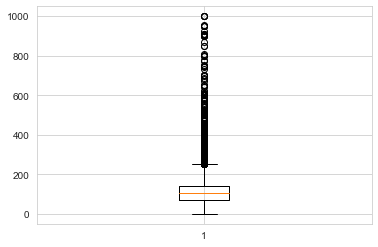

In [43]:
plt.boxplot(x=data['power']);

Посмотрим на нулевые значения.

In [44]:
data[data['power'] < 1]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,brand_type
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,1,petrol,volkswagen,unknown,2016-03-24,volkswagen
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,volkswagen
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,renault
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,7,NaN,opel,no,2016-03-17,opel
55,2016-03-26 10:39:35,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,2016-03-26,opel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354331,2016-04-04 14:41:28,390,small,1997,auto,0,corsa,100000,6,petrol,opel,yes,2016-04-04,opel
354332,2016-03-05 18:57:45,3299,NaN,2005,auto,0,outlander,150000,4,petrol,mitsubishi,unknown,2016-03-05,other
354334,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,unknown,2016-03-31,opel
354342,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,unknown,2016-03-07,mercedes_benz


Вероятно объявления, в которых значение мощности просто не было указано, их доля относительно всего объема - порядка 10%.

Предлагается нулевые значения заменить на основе средних значений по производителям и годам производства. Чтобы не переобучить модель указанную операцию целесообразно выполнить после разделения всей выборки на обучающую и тестовую (на обучающей собрать статистику и использовать ее для замены значений на обучающей и тестовой выборках).

Значения в интервале от 1 до 45 целесообразно удалить как выбросы.

Зона выбросов - значения свыше 300 л.с. также присутствует, но исключение этих данных нецелесообразно - в них присутствуют как ошибки (например mitsubishi colt мощностью 953 л.с.), так и верные данные (porsche cayenne 450 л.с.).

In [45]:
data = data.query('power == 0 or power >= 45')

Оценим распределение значений пробега.

In [46]:
data['kilometer'].value_counts()

150000    223348
125000     34519
100000     13575
90000      10934
80000       9439
70000       8057
60000       7033
50000       5815
40000       4613
30000       4034
5000        4028
20000       3489
10000        913
Name: kilometer, dtype: int64

Значения распределены в интервале от 5000 до 150000, в основном с шагом 10000. Вероятнее всего на ресурсе, с которого получены указанные объявления, ввод пробега осуществляется путем выбора из некоторого списка (судя по всему с ограничением: минимальное значение - от 0 до 5000, максимальное - свыше 150000).  Можно отметить, что признак пробега можно отнести к категориальным - количество уникальных значений ограничено (судя по всему, на указанном ресурсе выбор пробега осуществляется только путем выбора из списка значений).

Посмотрим на распределение видов топлива.

In [47]:
data['fuel_type'].value_counts()

petrol      203125
gasoline     95265
lpg           4966
cng            532
hybrid         205
other           91
electric        40
Name: fuel_type, dtype: int64

Распределение по виду топлива крайне неравномерно - 98% приходятся на виды топлива petrol и gasoline. Учитывая то, что указанные слова являются синонимами, целесообразно:

* заменить эти категории на одну
* имеющиеся пропуски (учитывая их существенный объем относительного всех данных) заменить также на наиболее частую категорию - petrol

Также целесообразно категории lpg и cng объединить в одну, поскольку они относятся к категории газового вида топлива. А оставшиеся категории малого объема предложений (гибридные, электродвигатели) исключить.

In [48]:
data.loc[data['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol'

In [49]:
data['fuel_type'] = data['fuel_type'].fillna('petrol')

In [50]:
data.loc[data['fuel_type'] == 'lpg', 'fuel_type'] = 'gas'
data.loc[data['fuel_type'] == 'cng', 'fuel_type'] = 'gas'

In [51]:
data = data.query('fuel_type in (\'petrol\', \'gas\')')

In [52]:
data['fuel_type'].value_counts()

petrol    323963
gas         5498
Name: fuel_type, dtype: int64

In [53]:
data['model'].value_counts()

golf                  27626
other                 21597
3er                   18892
polo                  12185
corsa                 11682
                      ...  
i3                        8
kalina                    6
rangerover                4
range_rover_evoque        2
serie_2                   2
Name: model, Length: 248, dtype: int64

In [54]:
data['model'].isnull().sum() / data.shape[0]

0.041048864660764094

Модельный ряд представлен списком из порядка 250 различных наименований. Учитывая то, что помимо пропусков в данных присутствует значение other (прочие модели), целесообразно заменить пропуски указанным значением.

In [55]:
data['model'] = data['model'].fillna('other')

Учитывая то, что уникальных значений признака модели достаточно много (около 250), целесообразно для обучения ML-модели создать производный признак, который бы содержал наиболее распространенные модели, а остальные относил бы к категории "прочие".

Указанную операцию выполним на этапе подготовки обучающей и тестовой выборок (по статистике обучающей выборки).

Посмотрим на типы коробки передач.

In [56]:
data['gearbox'].isnull().sum()

14665

In [57]:
data['gearbox'].value_counts()

manual    252724
auto       62072
Name: gearbox, dtype: int64

Соотношение ручная/автоматическая коробка передач - 4 к 1. Учитывая относительно небольшой объем пропусков данных, нецелесообразно выделять отдельную категорию (например, unknown) - имеет смысл заменить на наиболее распространенное значение - manual.

In [58]:
data['gearbox'] = data['gearbox'].fillna('manual')

Оценим распределение значений признака типа кузова.

In [59]:
data['vehicle_type'].value_counts()

sedan          87309
small          75610
wagon          63077
bus            27914
convertible    19050
coupe          14802
suv            11191
other           2678
Name: vehicle_type, dtype: int64

In [60]:
data['vehicle_type'].isnull().sum()

27830

Присутствуют данные с пропусками в типе кузова, при этом для многих подобных объявлений указаны марка и модель, что позволит выполнить замену, например, на наиболее распространенный тип кузова для модели.

Аналогично замене 0 признака мощности, чтобы не переобучить модель указанную операцию целесообразно выполнить после разделения всей выборки на обучающую и тестовую (на обучающей собрать статистику и использовать ее для замены значений на обучающей и тестовой выборках).

#### Разделение данных на обучающую и тестовую выборку. Заполнение пропусков на основе статистики в обучающей выборке.

Выполним стратифицированное разделение данных на обучающую и тестовую выборку. В качестве разделяющего признака используем добавленный выше признак brand_type, позволяющий отделить производителей, занимающих более 1% рынка от производителей с небольшой долей.

In [61]:
df_train, df_test = train_test_split(
        data, test_size=0.2, random_state=random_magic, stratify=data['brand_type']
    )

Подготовим статистические данные для замены пропусков/аномалий в признаках на основе имеющихся в обучающей выборке данных - значениях мощности и типа кузова для конкретных производителей и моделей автомобилей.

In [62]:
df_train = df_train.copy()
df_test = df_test.copy()

Определим медианные мощности по производителям и маркам автомобилей на основе данных обучающей выборки.

In [63]:
power_median = df_train.query('power > 0 and brand_type == \'other\'')['power'].median()
power_median

121.0

In [64]:
df_model_power = (
    df_train
    .query('power > 0')
    .groupby(['brand', 'model'])['power']
    .median()
    .reset_index()
)

df_model_power

,brand,model,power
0,alfa_romeo,145,103.0
1,alfa_romeo,147,120.0
2,alfa_romeo,156,150.0
3,alfa_romeo,159,174.0
4,alfa_romeo,other,150.0
...,...,...,...
289,volvo,v40,116.0
290,volvo,v50,136.0
291,volvo,v60,163.0
292,volvo,v70,163.0


In [65]:
def find_power_median_value(brand, model):
    """
    функция возвращает медианное значение мощности для входных параметров 
    brand - марка автомобиля
    model - модель автомобиля
    при отсутствии в таблице медианных значений указанной модели - возврат медианного значения мощности 
    по всей таблице (без учета пустых значений)
    
    """
    power_group = df_model_power.query('brand == @brand and model == @model')['power']

    if power_group.empty:
        return power_median
    else:
        return power_group.values[0]

Выполним замену в обучающей и тестовой выборках на основе сформированной статистики.

In [66]:
df_train.loc[df_train['power'] == 0,  'power'] = df_train.query('power == 0').apply(
    lambda row: find_power_median_value(row['brand'], row['model']),
    axis=1
).astype('int')

In [67]:
df_test.loc[df_test['power'] == 0, 'power'] = df_test.query('power == 0').apply(
    lambda row: find_power_median_value(row['brand'], row['model']),
    axis=1
).astype('int')

Определим наиболее часто встречаемые типы кузовов по производителям и моделям.

In [68]:
vehicle_type_top = df_train['vehicle_type'].mode()[0]
vehicle_type_top

'sedan'

In [69]:
df_model_vehicle_type = (
    df_train.groupby(['brand', 'model'])['vehicle_type'].
    agg(lambda x:x.value_counts().index[0])
    .reset_index()
)

df_model_vehicle_type

,brand,model,vehicle_type
0,alfa_romeo,145,small
1,alfa_romeo,147,sedan
2,alfa_romeo,156,wagon
3,alfa_romeo,159,wagon
4,alfa_romeo,other,sedan
...,...,...,...
290,volvo,v40,wagon
291,volvo,v50,wagon
292,volvo,v60,wagon
293,volvo,v70,wagon


In [70]:
def find_vehicle_type_top_value(brand, model):
    """
    функция возвращает медианное значение мощности для входных параметров 
    brand - марка автомобиля
    model - модель автомобиля
    при отсутствии в таблице медианных значений указанной модели - возврат медианного значения мощности 
    по всей таблице (без учета пустых значений)
    
    """
    vehicle_type_group = df_model_vehicle_type.query('brand == @brand and model == @model')['vehicle_type']

    if vehicle_type_group.empty:
        return vehicle_type_top
    else:
        return vehicle_type_group.values[0]

Аналогичным образом заполняем пропуски в обучающей и тестовой выборках

In [71]:
df_train.loc[df_train['vehicle_type'].isnull(),  'vehicle_type'] = (
    df_train.query('vehicle_type.isnull()', engine='python').apply(
    lambda row: find_vehicle_type_top_value(row['brand'], row['model']),
    axis=1)
)

In [72]:
df_test.loc[df_test['vehicle_type'].isnull(),  'vehicle_type'] = (
    df_test.query('vehicle_type.isnull()', engine='python').apply(
    lambda row: find_vehicle_type_top_value(row['brand'], row['model']),
    axis=1)
)

Добавим производный обучающий признак с целью выделить наиболее распространенные модели.

In [73]:
df_model_top = df_train.pivot_table(
    index='model', 
    values='brand', 
    aggfunc=['count']
).reset_index()

df_model_top.columns = ['model_top', 'count']
df_model_top = df_model_top.query('count > 1000')

In [74]:
df_train['model_type'] = df_train.merge(
    df_model_top, left_on='model', right_on ='model_top', how='left'
)['model_top']

df_train['model_type'] = df_train['model_type'].fillna('other')

In [75]:
df_test['model_type'] = df_test.merge(
    df_model_top, left_on='model', right_on ='model_top', how='left'
)['model_top']

df_test['model_type'] = df_test['model_type'].fillna('other')

Проверим общую информацию о признаках обучающей и тестовой выборок.

In [76]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263568 entries, 16916 to 43990
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        263568 non-null  datetime64[ns]
 1   price               263568 non-null  int64         
 2   vehicle_type        263568 non-null  object        
 3   registration_year   263568 non-null  int64         
 4   gearbox             263568 non-null  object        
 5   power               263568 non-null  int64         
 6   model               263568 non-null  object        
 7   kilometer           263568 non-null  int64         
 8   registration_month  263568 non-null  int64         
 9   fuel_type           263568 non-null  object        
 10  brand               263568 non-null  object        
 11  not_repaired        263568 non-null  object        
 12  date_created        263568 non-null  datetime64[ns]
 13  brand_type          263568

In [77]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65893 entries, 66494 to 315124
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date_crawled        65893 non-null  datetime64[ns]
 1   price               65893 non-null  int64         
 2   vehicle_type        65893 non-null  object        
 3   registration_year   65893 non-null  int64         
 4   gearbox             65893 non-null  object        
 5   power               65893 non-null  int64         
 6   model               65893 non-null  object        
 7   kilometer           65893 non-null  int64         
 8   registration_month  65893 non-null  int64         
 9   fuel_type           65893 non-null  object        
 10  brand               65893 non-null  object        
 11  not_repaired        65893 non-null  object        
 12  date_created        65893 non-null  datetime64[ns]
 13  brand_type          65893 non-null  objec

Пропуски заполнены, типы данных в обеих выборках совпадают. Можно переходить к этапу построения и обучения моделей.

### Выводы:

В таблице порядка 355 тысяч записей об объявлениях о продаже автомобилей. Целевым признаком является цена автомобиля (Price), указанная в евро.

Состав атрибутов совпадает с полученным описанием. Для удобства работы выполнено приведение названий атрибутов из 'верблюжьего' стиля в 'змеиный'.

Далее проведена оценка распределения значений признаков с целью выявления пропусков/аномалий в данных, которые целесообразно исключить или заменить.

По результатам оценки признаков, относящихся к самим объявлениям (дата создания, дата выгрузки), исключены аномалии - объявления с большим периодом экспозиции, которые вероятно содержат недостоверные ценовые характеристики. Также исключены аномальные значения года регистрации автомобилей, а также значения-выбросы, не дающие представления о текущем состоянии рынка автомобилей.

По результатам оценки числовых и категориальных признаков также устранены отдельные аномалии и выполнены замены пропусков значений.

После выполнения указанных операций в таблице осталось порядка 330 тясяч записей. Указанная выборка разделена на обучающую и тестовую (с пропорциональным разбиением по производителю). На основе статистики обучающей выборки выполнена замена пропусков значений мощности, типа кузова и модели автомобилей.

Данные подготовлены для этапа обучения моделей.

## Обучение моделей

Построим различные модели машинного обучения.

Определим наборы обучающих и целевого признаков, выделим категориальные и числовые (подлежащие масштабированию) признаки

In [78]:
features = ['vehicle_type',
            'registration_year',
            'gearbox',
            'power',
            'model_type',
            'kilometer',
            'registration_month',
            'fuel_type',
            'brand',
            'not_repaired']

features_category = ['vehicle_type', 'gearbox', 'model_type', 'kilometer', 
                     'registration_month', 'fuel_type', 'brand', 'not_repaired']

features_scale = ['registration_year', 'power']

target = ['price']

In [79]:
X_train = df_train[features]
Y_train = df_train[target]

X_test = df_test[features]
Y_test = df_test[target]

Создадим функцию расчета метрики RMSE

In [80]:
def rmse(Y_true, Y_predicted):
    return mean_squared_error(Y_true, Y_predicted) ** 0.5

In [81]:
scoring = make_scorer(rmse, greater_is_better=False)

Определим функции вывода значений метрики по результатам обучения и проверки моделей на тестовой выборке.

In [82]:
def print_scores(grid_search, params):
    """
    функция печати сводной информации о параметрах модели
    
    """
    print ('Наилучшее значение метрики RMSE: %0.3f' % np.abs(grid_search.best_score_))
    print ('Наилучшие параметры:')
    best_parameters = grid_search.best_estimator_.get_params()
    
    for param_name in sorted(params.keys()):
        print ('\t%s: %r' % (param_name, best_parameters[param_name]))

In [83]:
def print_scores_on_test(grid_search, params, X_test, Y_test):
    print ('Параметры модели:')
    best_parameters = grid_search.best_estimator_.get_params()
    grid_parameters = {}
    
    for param_name in sorted(params.keys()):
        grid_parameters[param_name] = best_parameters[param_name]
        print ('\t%s: %r' % (param_name, best_parameters[param_name]))
    
    score_value = np.abs(grid_search.score(X_test, Y_test))
    print('Значение метрики RMSE на тестовых данных:', score_value)
    
    return score_value, grid_parameters

Для последующего сравнения моделей объявим переменную для хранения статистической информации по качеству и времени обучения моделей.

In [84]:
ml_data = []

#### Dummy-модель


Для последующей оценки полученных результатов проверки моделй на тестовых данных рассмотрим несколько dummy-моделей, выполняющий предсказание по одному из простых принципов:

* медианное значение цены
* среднее значение по бренду
* среднее значение по модели

In [85]:
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train, Y_train)

print(
    'Значение dummy метрики RMSE на тестовых данных:', 
    rmse(Y_test.values.ravel(), dummy.predict(X_test)) 
)

Значение dummy метрики RMSE на тестовых данных: 4801.802663452178


In [86]:
df_brand_median_price = df_train.pivot_table(
    index='brand', 
    values='price', 
    aggfunc=['mean']
).reset_index()

df_brand_median_price.columns = ['brand', 'price']

In [87]:
predictions = df_test.merge(
    df_brand_median_price, left_on='brand', right_on ='brand', how='inner'
)['price_y']

print(
    'Значение dummy метрики RMSE на тестовых данных:', 
    rmse(Y_test.values.ravel(), predictions) 
)

Значение dummy метрики RMSE на тестовых данных: 4749.411496412639


In [88]:
df_model_median_price = df_train.pivot_table(
    index='model_type', 
    values='price', 
    aggfunc=['mean']
).reset_index()

df_model_median_price.columns = ['model_type', 'price']

In [89]:
predictions = df_test.merge(
    df_model_median_price, left_on='model_type', right_on ='model_type', how='inner'
)['price_y']

print(
    'Значение dummy метрики RMSE на тестовых данных:', 
    rmse(Y_test.values.ravel(), predictions) 
)

Значение dummy метрики RMSE на тестовых данных: 4499.532295842008


Базовое значение ошибки для построения моделей машинного обучения получено.

In [90]:
ml_data.append(['dummy', 0, 0, 4499, {}])

In [91]:
cv_folds = 5
simple_param = True

#### Линейная регрессия

В качестве шагов преобразования данных определим масштабирование и кодирование с помощью OrdinalEncoder (целочисленный код категории). Указанный способ кодирования категориальных признаков ближе к применяемым к CatBoost и LightGBM численным способам кодирования.

In [92]:
transform_steps = [
    (
        'qtl', ColumnTransformer(
            remainder='passthrough',
            transformers=[  
                ('std', StandardScaler(copy=False, with_mean=True, with_std=True), features_scale),
                ('cat', OrdinalEncoder(), features_category)
            ])
    ),
]

In [93]:
model_lr = LinearRegression()

params = {
    'model__fit_intercept': [True, False],
    'model__normalize': [True, False]
}

In [94]:
def get_param_count(params):
    return np.prod([len(value) for key, value in params.items()])

In [95]:
grid_search = GridSearchCV(
        Pipeline(transform_steps + [('model', model_lr)]), 
        param_grid=params, 
        cv=cv_folds, 
        scoring=scoring,
    ) 

In [96]:
%%time
start_time = datetime.datetime.now()

grid_search.fit(X_train, Y_train.values.ravel())

learning_time = (datetime.datetime.now()-start_time).seconds

print_scores(grid_search, params)

Наилучшее значение метрики RMSE: 3006.642
Наилучшие параметры:
	model__fit_intercept: True
	model__normalize: True
CPU times: user 17.7 s, sys: 1.49 s, total: 19.2 s
Wall time: 13.4 s


In [97]:
rmse_score, grid_parameters = print_scores_on_test(grid_search, params, X_test, Y_test.values.ravel())

ml_data.append(['Линейная регрессия', learning_time, learning_time / get_param_count(params), rmse_score, grid_parameters])

Параметры модели:
	model__fit_intercept: True
	model__normalize: True
Значение метрики RMSE на тестовых данных: 2978.0705925200737


С помощью линейной регрессии удалось достичь значения метрики RMSE = 2978, что  в 1.5 раза лучше, чем dummy-модель

#### Случайный лес

Рассмотрим модель случайного леса. В качестве диапазона перебираемых гиперпараметров укажем глубину дерева и количество деревьев в лесу.

In [98]:
model_rfr = RandomForestRegressor(random_state=random_magic)

params = {
    'model__n_estimators': [10, 20, 30],
    'model__max_depth': [2, 3, 5],
}

if simple_param:
    params = {
        'model__n_estimators': [30],
        'model__max_depth': [5],
    }

In [99]:
grid_search = GridSearchCV(
        Pipeline(transform_steps + [('model', model_rfr)]), 
        param_grid=params, 
        cv=cv_folds, 
        scoring=scoring,
    )

In [100]:
%%time
start_time = datetime.datetime.now()

grid_search.fit(X_train, Y_train.values.ravel())

learning_time = (datetime.datetime.now()-start_time).seconds

print_scores(grid_search, params)

Наилучшее значение метрики RMSE: 2351.839
Наилучшие параметры:
	model__max_depth: 5
	model__n_estimators: 30
CPU times: user 53.9 s, sys: 866 ms, total: 54.8 s
Wall time: 1min 3s


In [101]:
rmse_score, grid_parameters = print_scores_on_test(grid_search, params, X_test, Y_test.values.ravel())

ml_data.append(['Случайный лес', learning_time, learning_time / get_param_count(params), rmse_score, grid_parameters])

Параметры модели:
	model__max_depth: 5
	model__n_estimators: 30
Значение метрики RMSE на тестовых данных: 2351.304181088137


Модель случайного леса позволила получить значения метрики RMSE = 2351, что более чем на 20% лучше модели линейной регрессии.

#### CatBoost

Рассмотрим модель градиентного бустинга CatBoostRegressor. В качестве метрики используем RMSE

In [102]:
class RmseMetric(object):
    def get_final_error(self, error, weight):
        return np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((approx[i] - target[i])**2)

        return error_sum, weight_sum

In [103]:
model_cbr = CatBoostRegressor(
    verbose=50,
    #eval_metric='RMSE',
    eval_metric=RmseMetric(),
    cat_features=features_category,
    task_type="CPU",
    iterations=1000,  
)

params = {
    'learning_rate': [0.03, 0.05, 0.15],
    'depth': [5, 7, 10],
}

if simple_param:
    params = {
        'learning_rate': [0.15],
        'depth': [7],
    }

In [104]:
%%time

start_time = datetime.datetime.now()

model_cbr.fit(
    df_train[features], df_train[target],
    plot=True
)

learning_time = (datetime.datetime.now()-start_time).seconds

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.098783
0:	learn: 4208.0865841	total: 1.88s	remaining: 31m 17s
50:	learn: 1862.5134627	total: 13.8s	remaining: 4m 17s
100:	learn: 1787.5048895	total: 24.4s	remaining: 3m 36s
150:	learn: 1750.8406715	total: 35.7s	remaining: 3m 20s
200:	learn: 1724.0026893	total: 46.6s	remaining: 3m 5s
250:	learn: 1703.6899139	total: 56.8s	remaining: 2m 49s
300:	learn: 1687.1008751	total: 1m 9s	remaining: 2m 40s
350:	learn: 1674.8980149	total: 1m 18s	remaining: 2m 25s
400:	learn: 1664.2197974	total: 1m 27s	remaining: 2m 10s
450:	learn: 1656.4533143	total: 1m 38s	remaining: 1m 59s
500:	learn: 1649.5476605	total: 1m 49s	remaining: 1m 49s
550:	learn: 1641.9503712	total: 2m	remaining: 1m 38s
600:	learn: 1636.0868898	total: 2m 9s	remaining: 1m 25s
650:	learn: 1630.6794530	total: 2m 18s	remaining: 1m 14s
700:	learn: 1626.1664289	total: 2m 30s	remaining: 1m 4s
750:	learn: 1622.1568455	total: 2m 39s	remaining: 52.9s
800:	learn: 1617.9662881	total: 2m 50s	remaining: 42.4s
850:	learn: 1614.56

In [105]:
rmse_score = rmse(Y_test.values.ravel(), model_cbr.predict(X_test))

print('Значение метрики RMSE на тестовых данных:', rmse_score)

ml_data.append(['CatBoost', learning_time, learning_time / get_param_count(params), rmse_score, {}])

Значение метрики RMSE на тестовых данных: 1633.1581597660163


Модель CatBoostRegressor библиотеки CatBoost позволила получить значение метрики RMSE на тестовых данных ~ 1633, что ниже рассмотренных выше моделей.

#### LightGBM

Рассмотрим модель градиентного бустинга LGBMRegressor.

Поскольку для модели LGBMRegressor категориальные признаки требуются в формате категориальных типов данных - выполним склейку обучающей и тестовой выборки, преобразование категориальных типов и последующее обратное разделение (по имеющимся индексам).

In [106]:
df_lgbm = df_train.append(df_test)

In [107]:
for c in df_lgbm.columns:
    col_type = df_lgbm[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df_lgbm[c] = df_lgbm[c].astype('category')

In [108]:
df_train_lgbm = df_lgbm.loc[df_train.index]
df_test_lgbm = df_lgbm.loc[df_test.index]

In [109]:
X_train_lgbm = df_train_lgbm[features]
Y_train_lgbm = df_train_lgbm[target]

X_test_lgbm = df_test_lgbm[features]
Y_test_lgbm = df_test_lgbm[target]

In [110]:
model_lgbm = lgb.LGBMRegressor(
    random_state=random_magic,
    device="cpu"
)

params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.03, 0.05, 0.15],
}

if simple_param:
    params = {
        'max_depth': [7],
        'learning_rate': [0.15],
    }

In [111]:
%%time

start_time = datetime.datetime.now()

grid_search = GridSearchCV(
        estimator=model_lgbm,
        param_grid=params, 
        cv=cv_folds, 
        scoring=scoring,
        n_jobs=-1, 
        verbose=5
    )
fitted_model = grid_search.fit(X_train_lgbm, Y_train_lgbm)

learning_time = (datetime.datetime.now()-start_time).seconds

print_scores(grid_search, params)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Наилучшее значение метрики RMSE: 1685.910
Наилучшие параметры:
	learning_rate: 0.15
	max_depth: 7
CPU times: user 4.11 s, sys: 296 ms, total: 4.4 s
Wall time: 14.5 s


In [112]:
rmse_score, grid_parameters = print_scores_on_test(grid_search, params, X_test_lgbm, Y_test_lgbm.values.ravel())

ml_data.append(['LightGBM', learning_time, learning_time / get_param_count(params), rmse_score, grid_parameters])

Параметры модели:
	learning_rate: 0.15
	max_depth: 7
Значение метрики RMSE на тестовых данных: 1669.4617886842987


Модель LGBMRegressor библиотеки LightGBM позволила получить значение метрики RMSE на тестовых данных ~ 1669, что немного хуже CatBoost.

## Анализ моделей

In [113]:
df_ml_compare = pd.DataFrame(ml_data, columns=['model', 'learning_time', 'learning_time_per_param', 'rmse', 'params'])
df_ml_compare

,model,learning_time,learning_time_per_param,rmse,params
0,dummy,0,0.00,4499.000000,{}
1,Линейная регрессия,13,3.25,2978.070593,"{'model__fit_intercept': True, 'model__normali..."
2,Случайный лес,63,63.00,2351.304181,"{'model__max_depth': 5, 'model__n_estimators':..."
3,CatBoost,209,209.00,1633.158160,{}
4,LightGBM,14,14.00,1669.461789,"{'learning_rate': 0.15, 'max_depth': 7}"


[CV 4/5] END learning_rate=0.15, max_depth=7;, score=-1689.594 total time=   4.7s
[CV 2/5] END learning_rate=0.15, max_depth=7;, score=-1686.659 total time=   4.8s
[CV 3/5] END learning_rate=0.15, max_depth=7;, score=-1682.570 total time=   5.1s
[CV 1/5] END learning_rate=0.15, max_depth=7;, score=-1692.924 total time=   4.6s
[CV 5/5] END learning_rate=0.15, max_depth=7;, score=-1677.804 total time=   2.0s


Линейная регрессия позволила получить значение метрики равное ~ 2978, случайный лес ~ 2351, обе модели градиентного бустинга ~ 1633-1669. Все из перечисленных моделей значительно улучшили предсказание dummy-моделей (~ 4500), при этом качество моделей градиентного бустинга почти в 2 раза лучше линейной регрессии и на 25% лучше случайного леса.

Время обучения модели градиентного бустинга LGBMRegressor незначительно превышает время обучения линейной регрессии. 

Качество моделей градиентного бустинга на 25% выше случайного леса и существенного превосходят оценки dummy-модели. Время обучения CatBoost относительно LightGBM на порядок хуже.

### Выводы:

В рамках исследования проведено построение моделей машинного обучения с целью предсказания на основе технических характеристик цены автомобилей.

Проведена обработка данных (порядка 355 тысяч записей об объявлениях о продаже автомобилей):

* проведена оценка распределения значений признаков с целью выявления пропусков/аномалий в данных, которые целесообразно исключить или заменить.
* по результатам оценки признаков, относящихся к самим объявлениям (дата создания, дата выгрузки), исключены аномалии - объявления с большим периодом экспозиции, которые вероятно содержат недостоверные ценовые характеристики. Также исключены аномальные значения года регистрации автомобилей, а также значения-выбросы, не дающие представления о текущем состоянии рынка автомобилей.
* по результатам оценки числовых и категориальных признаков также устранены отдельные аномалии и выполнены замены пропусков значений.

После выполнения указанных операций в таблице осталось порядка 330 тысяч записей. Указанная выборка разделена на обучающую и тестовую (с пропорциональным разбиением по производителю). На основе статистики обучающей выборки выполнена замена пропусков значений мощности, типа кузова и модели автомобилей.

Проведено обучение 4 различных типов моделей:

* линейная регрессия
* случайный лес
* градиентный бустинг CatBoost
* градиентный бустинг LightGBM

Линейная регрессия позволила получить значение метрики равное ~ 2978, случайный лес ~ 2351, обе модели градиентного бустинга ~ 1633-1669. Все из перечисленных моделей значительно улучшили предсказание dummy-моделей (~ 4500), при этом качество моделей градиентного бустинга почти в 2 раза лучше линейной регрессии и на 25% лучше случайного леса.

Время обучения модели градиентного бустинга LGBMRegressor незначительно превышает время обучения линейной регрессии. 

Качество моделей градиентного бустинга на 25% выше случайного леса и существенного превосходят оценки dummy-модели. Время обучения CatBoost относительно LightGBM на порядок хуже.